# Tutorial 3: Initializing a large-scale chain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [2]:
# load compiled bed elevation measurements
df = pd.read_csv('../data/KohlerPopeSmith.csv')

In [3]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmachine_bed = df['bedmap_surf'].values.reshape(xx.shape) - bedmachine_thickness

In [6]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmachine_bed)
df['cond_bed'] = cond_bed.flatten()
# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

In [ ]:
#FIXME do not crop bedmap mask

(-1627000.0, -1357000.0, -751000.0, -520500.0)

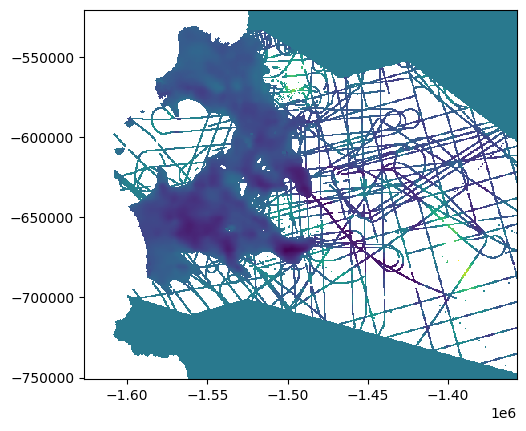

In [7]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [8]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

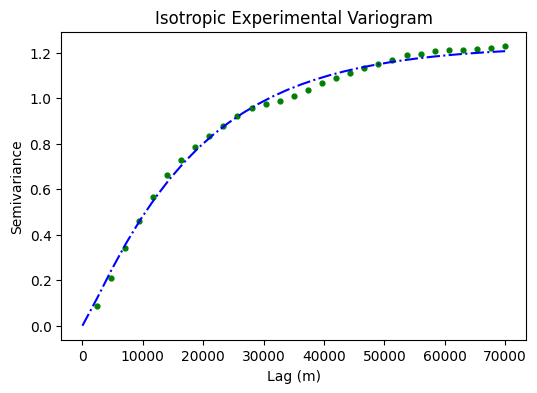

In [ ]:
#FIXME Don't follow the note
#NOTE Drop NA values to avoid errors when computing variogram
df_to_sample = df[~df['bed'].isna()]

# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df_to_sample.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 70000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern')

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [15]:
V1_p

[51459.95234429779, 1.2307482653414321, 0.5862981719693362, 0]

In [ ]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('sgs_bed.txt') #NOTE use T2 to generate sgs_bed.txt
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [24]:
grounded_ice_mask = (bedmap_mask == 1)

In [25]:
largeScaleChain = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


Now, the object 'largeScaleChain' have all the properties you have assigned in the initialization process. Try typing *largeScaleChain.xx* or *largeScaleChain.cond_bed*, or any other argument to check them.

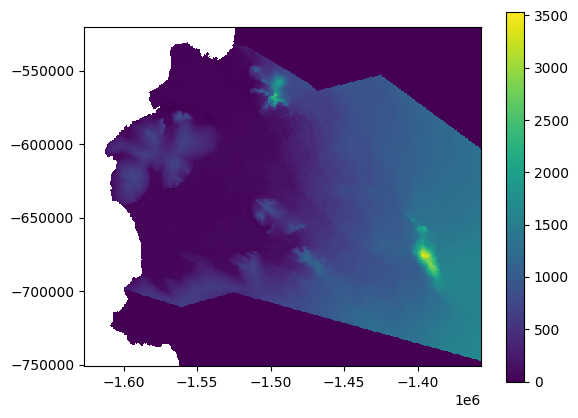

In [30]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

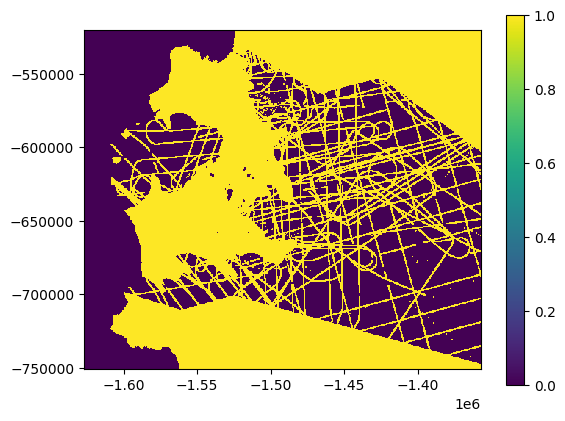

In [31]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

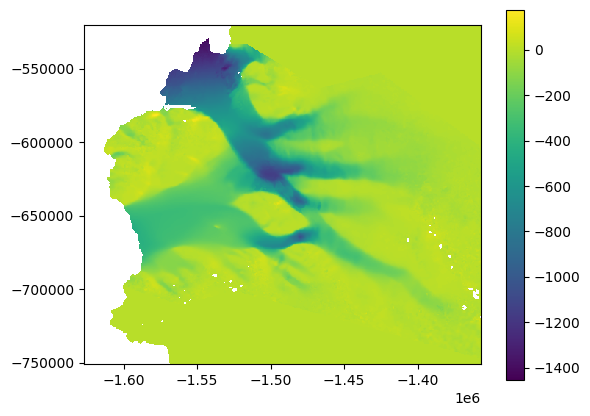

In [32]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

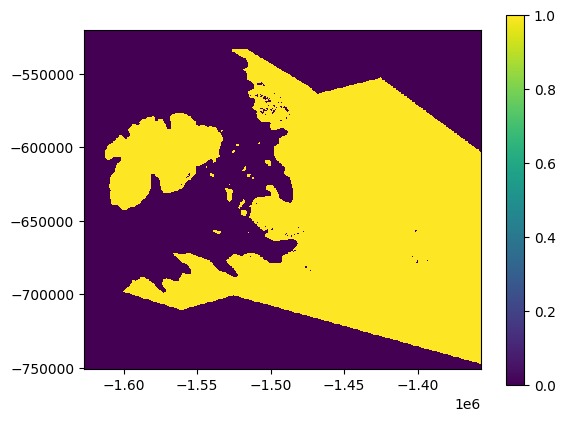

In [33]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

The second function required, is *set_update_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [34]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


We also want to specify how we want to define the loss function used in the chain.

*map_func* determine the distribution of mass conservation residuals, whereas the *diff_func* determine the distribution of the difference between radar measurements and simulated topography. If the residuals has a Gaussian distribution, the corresponding function will be 'sumsquare'. If you do not want to include either of these loss, simple put *map_func = None* or *diff_func = None*. 

*sigma_mc* and *sigma_data* determine the standard deviation of the distribution of mass conservation residual or differences to radar data. *massConvInRegion* and *dataDiffInRegion* specify whether the two losses should be calculated for only inside the high velocity region or not

In [35]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

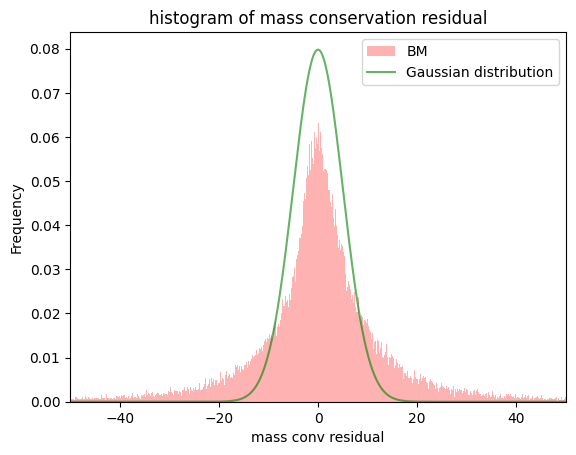

In [38]:
sigma3 = 5
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

In [ ]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=sigma3, massConvInRegion=True) #NOTE Change sigma_mc here also

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [ ]:
range_max_x = 56e3 #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = 56e3
range_min_x = 10e3
range_min_y = 10e3

#FIXME amplitude of perturbation. Make larger
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 150
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

Before using the `RandField` object in an MCMC chain or for field generation, call method `set_block_sizes` and method`set_weight_param` to initialize block size ranges and conditional weighting parameters.


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [41]:
min_block_x = 50
max_block_x = 80
min_block_y = 50
max_block_y = 80
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [42]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

#### Run the Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [43]:
largeScaleChain.set_crf_data_weight(rf1)
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


In [44]:
np.savetxt('data_weight.txt', largeScaleChain.crf_data_weight)

In [45]:
largeScaleChain.crf_data_weight = np.loadtxt('data_weight.txt')
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


__store the data weights for demonstration in class__

And then we can start the chain by specifying how many iterations it should go through

In [46]:
seed = 20251019
rng = np.random.default_rng(seed)

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=500, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)

i: 100 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9900990099009901
i: 200 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9950248756218906
i: 300 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9966777408637874
i: 400 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9975062344139651


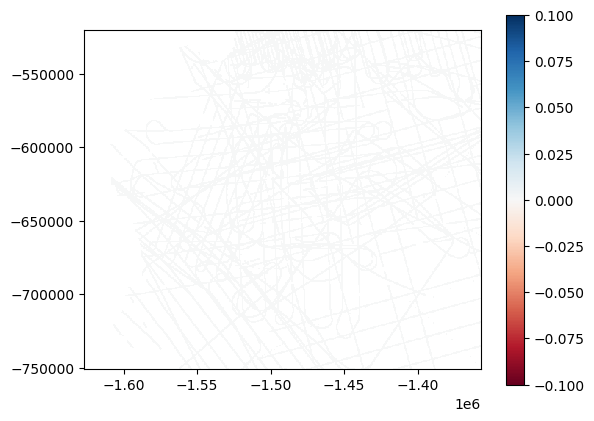

In [47]:
plt.pcolormesh(xx,yy,beds[-1]-beds[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

A chain can be continued by assigning the initial bed

**NOTICE:** If we use the same seed as before, then the exact same randomness will be impose in the algorithm, and the MCMC will propose the exact same perturbation as in your first run. To add randomness to the MCMC, I recommend to continue the chain with a different seed

In [48]:
largeScaleChain.initial_bed = beds[-1]

beds2, loss_mc2, loss_data2, loss2, steps2, resampled_times2, blocks_used2 = largeScaleChain.run(n_iter=500, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)

i: 100 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9900990099009901
i: 200 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9950248756218906
i: 300 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9966777408637874
i: 400 mc loss: 2.279e+05 data loss: 0.000e+00 loss: 2.279e+05 acceptance rate: 0.9975062344139651


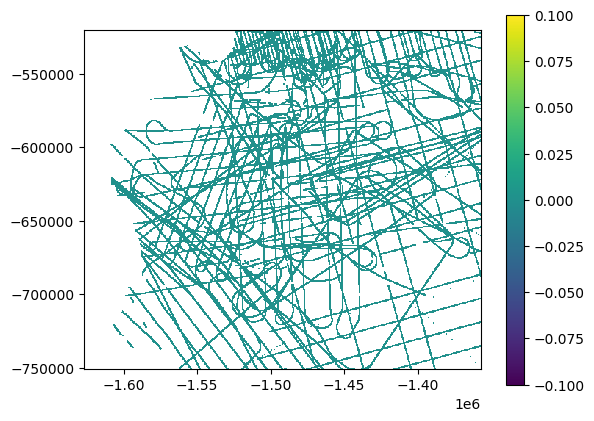

In [49]:
plt.pcolormesh(xx,yy,beds[-1] - beds2[0],cmap='viridis')
plt.axis('scaled')
plt.colorbar()

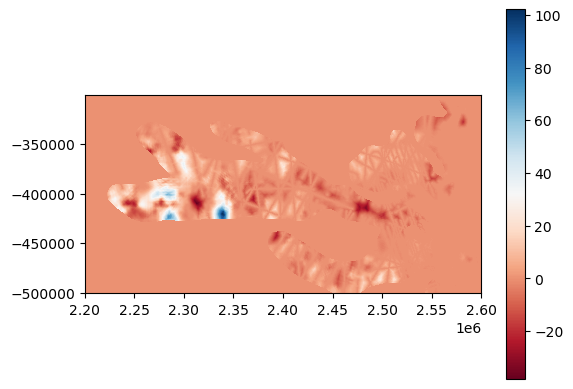

In [37]:
plt.pcolormesh(xx,yy,beds2[-1]-beds2[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

In [ ]:
#NOTE seafloor constraint for topography. Don't use for variogram!
#NOTE Look for parameters to tune/decrease the acceptance rate